In [35]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import seaborn as sn
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import auc
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
# Import module for data visualization
from plotnine import *
import plotnine

In [8]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point


def ROC(label, y_prob):
    fpr, tpr, thresholds = roc_curve(label, y_prob)
    roc_auc = auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_th, optimal_point
    

In [36]:
# Data Loading
f = r'C:\Users\User\VSCode\CDSS(20220401).xlsx'

CDSS = pd.read_excel(f, dtype={'病歷號碼':'str'})
m = CDSS[CDSS.openTime==CDSS.minTime]

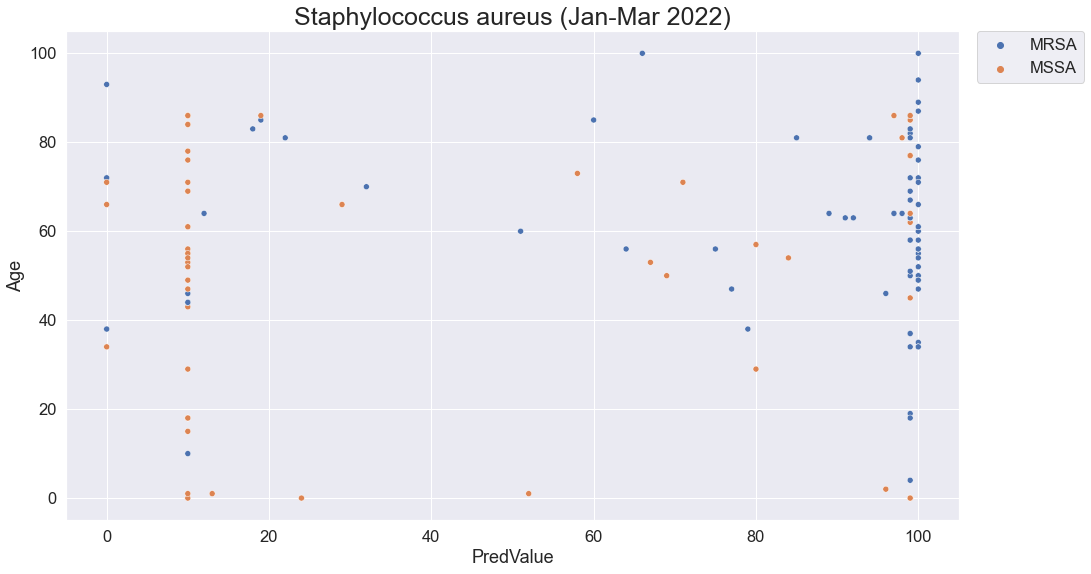

Strain: Staphylococcus aureus (Jan-Mar 2022)
Amount: 149
Patient: 95

PredLevel  Resist
0~20%      MRSA      14
           MSSA      35
21~40%     MRSA       2
           MSSA       2
41~60%     MRSA       2
           MSSA       2
61~80%     MRSA       5
           MSSA       5
81~100%    MRSA      68
           MSSA      14
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,49.0,9.000000,4.541476,0.0,10.00,10.0,10.00,19.0
21~40%,4.0,26.750000,4.573474,22.0,23.50,26.5,29.75,32.0
41~60%,4.0,55.250000,4.425306,51.0,51.75,55.0,58.50,60.0
61~80%,10.0,72.800000,6.142746,64.0,67.50,73.0,78.50,80.0
81~100%,82.0,98.426829,2.981550,84.0,99.00,99.0,100.00,100.0


In [37]:
# Staphylococcus aureus

SA = m[(m['菌株'] == 'Staphylococcus aureus')|(m['菌株'] == 'Staphylococcus aureus(MRSA)')]
SA = SA.drop_duplicates() 

SA = SA[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #101
SA['STRAIN'] = 'Staphylococcus aureus'

# add column 'predValue interval'
condition = [(SA['預測值'] <= 20), (SA['預測值'] > 20)&(SA['預測值'] <= 40), 
             (SA['預測值'] > 40)&(SA['預測值'] <= 60), (SA['預測值'] > 60)&(SA['預測值'] <= 80),
             (SA['預測值'] > 80)&(SA['預測值'] <= 100)]

value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
SA['PredLevel'] = np.select(condition, value)

# add column 'Resistance'
SA['Resist'] = np.where(SA['抗藥性菌株']==1, 'MRSA', 'MSSA')
SA['Resist_bool'] = np.where(SA['Resist']=='MRSA', 1, 0)
SA.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Staphylococcus aureus (Jan-Mar 2022)', fontsize = 25)
# Acinetobacter baumannii   AB  CRAB    CSAB
# Staphylococcus aureus     SA	MRSA	MSSA
# Escherichia coli          EC	CREC	CSEC
# Pseudomonas aeruginosa    PA	CRPA	CSPA
# Klebsiella pneumoniae     KP	CRKP	CSKP
# Morganella morganii       MM	CRMM	CSMM
# Enterococcus faecium      EF	VRE		VSE

ax = sn.scatterplot(data=SA, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Staphylococcus aureus (Jan-Mar 2022)')
print('Amount:', SA['病歷號碼'].count())
print('Patient:', SA['病歷號碼'].drop_duplicates().count())
print()
print(SA.groupby('PredLevel')['Resist'].value_counts().sort_index())
SA.groupby('PredLevel')['PredValue'].describe()



<function matplotlib.pyplot.show(close=None, block=None)>

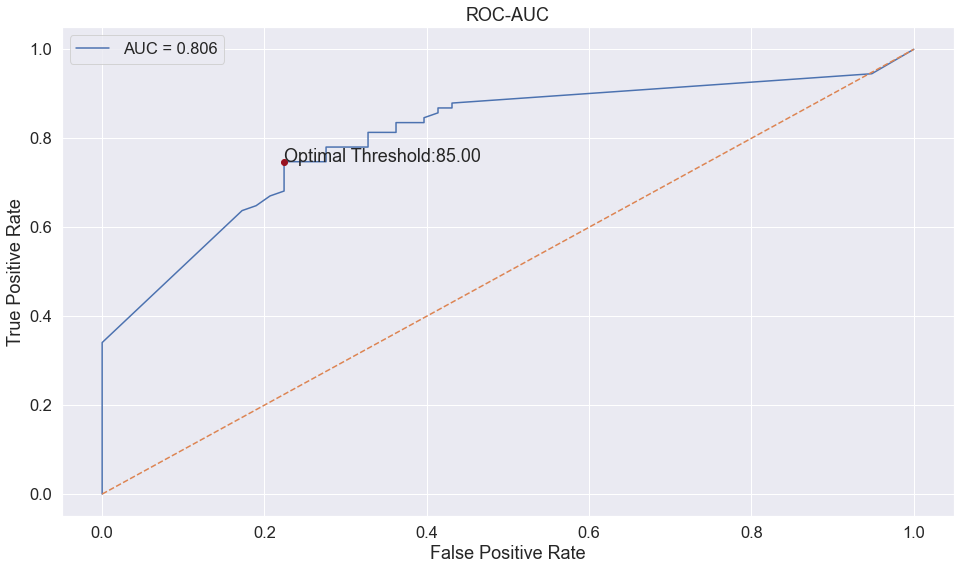

In [38]:
# Create the ROC curve
# fpr, tpr, thresholds = roc_curve(SA['Resist_bool'], SA.PredValue)

fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(SA['Resist_bool'], SA.PredValue)

plt.figure(figsize=(16, 9))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(optimal_point[0], optimal_point[1], marker="o", color="#981220")
plt.text(optimal_point[0], optimal_point[1], f'Optimal Threshold:{optimal_th:.2f}')
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show

Predicted  MRSA  MSSA
Actual               
MRSA         68    23
MSSA         14    44


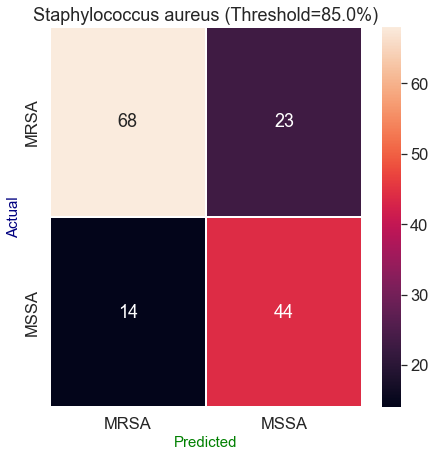

In [39]:
# confusion matrix
SA['Threshold'] = np.where(SA.PredValue>optimal_th, 'MRSA', 'MSSA')
SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
confusion_matrix_SA = pd.crosstab(SA['Resist'], SA['Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix_SA)


plt.figure(figsize=(7,7))
sn.set(font_scale = 1.5)
sn.heatmap(confusion_matrix_SA, annot=True, fmt='d', linewidths=1.5)
plt.title(f'Staphylococcus aureus (Threshold={optimal_th:.1f}%)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15, color='green')
plt.ylabel('Actual', fontsize = 15, color='navy')
plt.show()

In [ ]:
pieData = SA['部位'].value_counts()
label = pieData.index

colors = sn.color_palette('pastel')

#create pie chart
sn.set(font_scale = 1.5)
plt.figure(figsize=(25,25))
plt.pie(pieData, labels = label, autopct='%.2f%%', colors=colors)
plt.title('Position of Staphylococcus aureus (Jan-Mar 2022)', fontsize = 25)
plt.show()

In [42]:
m['病歷號碼'].drop_duplicates()

20752    0036984922
20788    0011798993
21087    0017896571
21268    0037886792
21396    0037957068
            ...    
99622    0038227740
99627    0017950548
99759    0038220606
99868    0036261148
99880    0024270674
Name: 病歷號碼, Length: 562, dtype: object